In [8]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import random
import seaborn as sns
import colorsys

In [9]:
params = pd.read_csv('data2.csv')
params.head()

,unit,m_cost,e_cost,m_prod,e_prod,ubt,bp
0,wind,45,175,0.0,8,17,0
1,solar,150,0,0.0,20,28,0
2,ec,1,1250,1.0,-70,27,0
3,solar_adv,370,4000,0.0,75,82,0
4,nano,210,3200,0.0,0,53,200


In [10]:
initial_state = {
        'unit': ['com', 'mex', 'solar', 'wind','con', 'ec', 'nano', 'solar_adv'],
        'cnt': [1, 3, 2, 3, 1, 0, 0, 0]
       }

df = pd.DataFrame(initial_state)
df.to_csv('initial_t1.csv')
df.head(2)

,unit,cnt
0,com,1
1,mex,3


In [11]:
# Merge the two dataframes based on the 'entity' and 'name' columns
merged_df = pd.merge(df, params, left_on='unit', right_on='unit', how='left')
merged_df

,unit,cnt,m_cost,e_cost,m_prod,e_prod,ubt,bp
0,com,1,2700,26000,2.0,25,150,300
1,mex,3,50,500,1.8,-3,19,0
2,solar,2,150,0,0.0,20,28,0
3,wind,3,45,175,0.0,8,17,0
4,con,1,120,1750,0.0,0,36,80
5,ec,0,1,1250,1.0,-70,27,0
6,nano,0,210,3200,0.0,0,53,200
7,solar_adv,0,370,4000,0.0,75,82,0


In [12]:
bp_sum = (merged_df.bp*merged_df['cnt']).sum()
bp_sum

380

In [13]:
class Fork:
    def __init__(self, df):
        self.time = 0
        self.e_amount = 0
        self.m_amount = 0
        self.df = pd.DataFrame(df)
        self.unit = ''
        self.bt = 0
        self.branches = []
        self.name = ''

In [14]:
branch = Fork(merged_df)
branch.time = 92
branch.df = merged_df
branch.e_amount = 78
branch.m_amount = 255
branch.unit = 'con'
branch.bt = merged_df[merged_df['unit'] == 'con']['ubt'].values[0]/300 # By com

def fill_branches(parent_fork):
    # Print the current state
    # print('> unit:', parent_fork.unit)
    print('> time:', parent_fork.time)
    # print('> e_amount:', parent_fork.e_amount)
    # print('> m_amount:', parent_fork.m_amount)
    e_prod = (parent_fork.df.e_prod * parent_fork.df['cnt']).sum()
    m_prod = (parent_fork.df.m_prod * parent_fork.df['cnt']).sum()
    # Print debug e_prod, m_prod
    # print(f'> e_prod: {e_prod}')
    # print(f'> m_prod: {m_prod}')
    candidates = ['solar','wind','solar_adv','ec']
    for candidate in candidates:
        row = parent_fork.df[parent_fork.df['unit'] == candidate]
        e_cost = row['e_cost'].values[0]
        m_cost = row['m_cost'].values[0]
        bp_sum = (parent_fork.df.bp*parent_fork.df['cnt']).sum()
        bt = row['ubt'].values[0]*100/bp_sum
        
        if e_cost > parent_fork.e_amount + e_prod * bt \
            or m_cost > parent_fork.m_amount + m_prod * bt:
            # print('not enough resources:', candidate, e_cost, m_cost)
            continue
        
        # print('candidate:', candidate, e_cost, m_cost)
        fork = Fork(parent_fork.df.copy())  # Create a new copy of the DataFrame
        fork.unit = candidate
        fork.bt = bt
        fork.time = parent_fork.time + fork.bt
        fork.e_amount = parent_fork.e_amount - e_cost + e_prod * bt
        fork.m_amount = parent_fork.m_amount - m_cost + m_prod * bt
        
        # Update the count for the specific row
        row_index = fork.df.index[fork.df['unit'] == candidate].tolist()[0]
        # print(f"<# {parent_fork.df.loc[parent_fork.df['unit'] == candidate, 'm_cost']}")
        fork.df.iloc[row_index, fork.df.columns.get_loc('cnt')] += 1
        
        fork.name = parent_fork.name + '-' + candidate
        # print(f"< name: {fork.name}, count: {fork.df.loc[fork.df['unit'] == candidate, 'cnt'].values[0]}")
        if fork.time > 120:
            print('time is over:', fork.time)
            return 
        fill_branches(fork)
        parent_fork.branches.append(fork)

fill_branches(branch)

> time: 92
> time: 99.36842105263158
> time: 106.73684210526315
> time: 111.21052631578947
> time: 115.68421052631578
time is over: 120.1578947368421
> time: 118.3157894736842
time is over: 125.68421052631578
> time: 113.84210526315789
time is over: 121.21052631578947
> time: 103.84210526315789
> time: 111.21052631578947
> time: 115.68421052631578
time is over: 120.1578947368421
> time: 118.3157894736842
time is over: 125.68421052631578
> time: 108.3157894736842
> time: 115.68421052631578
time is over: 120.1578947368421
> time: 112.78947368421052
time is over: 120.1578947368421
> time: 115.42105263157895
time is over: 122.78947368421052
> time: 110.94736842105263
> time: 118.3157894736842
time is over: 125.68421052631578
> time: 115.42105263157895
time is over: 122.78947368421052
> time: 106.47368421052632
> time: 113.84210526315789
time is over: 121.21052631578947
> time: 110.94736842105263
> time: 118.3157894736842
time is over: 125.68421052631578
> time: 115.42105263157895
time is o

In [15]:
# calculate the overall forks count
def count_forks(fork, biggest_e_prod):
    count = 1
    for branch in fork.branches:
        count += count_forks(branch, biggest_e_prod)
        # if (branch.df.m_prod*branch.df['cnt']).sum() > 7.4:
        e_prod = (branch.df.e_prod*branch.df['cnt']).sum()
        m_prod = (branch.df.m_prod*branch.df['cnt']).sum()
        if e_prod >= biggest_e_prod:
            biggest_e_prod = e_prod
            print(branch.name, 'e', (branch.df.e_prod*branch.df['cnt']).sum(), 'm', (branch.df.m_prod*branch.df['cnt']).sum(), 't', int(branch.time))
    return count

biggest_e_prod = 0
print('total forks:', count_forks(branch, biggest_e_prod))

-solar-solar-wind-wind e 136 m 7.4 t 115
-solar-solar-wind e 128 m 7.4 t 111
-solar-solar e 120 m 7.4 t 106
-solar-wind-solar-wind e 136 m 7.4 t 115
-solar-wind-solar e 128 m 7.4 t 111
-solar-wind-wind-solar e 136 m 7.4 t 115
-solar e 100 m 7.4 t 99
-wind-solar-solar-wind e 136 m 7.4 t 115
-wind-solar-solar e 128 m 7.4 t 111
-wind-solar-wind-solar e 136 m 7.4 t 115
-wind-solar e 108 m 7.4 t 103
-wind-wind-solar-solar e 136 m 7.4 t 115
-wind-wind-solar e 116 m 7.4 t 108
-wind-wind-wind-solar e 124 m 7.4 t 112
-wind-wind-wind-wind-solar e 132 m 7.4 t 117
total forks: 49


/tmp/ipykernel_28217/3751915584.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


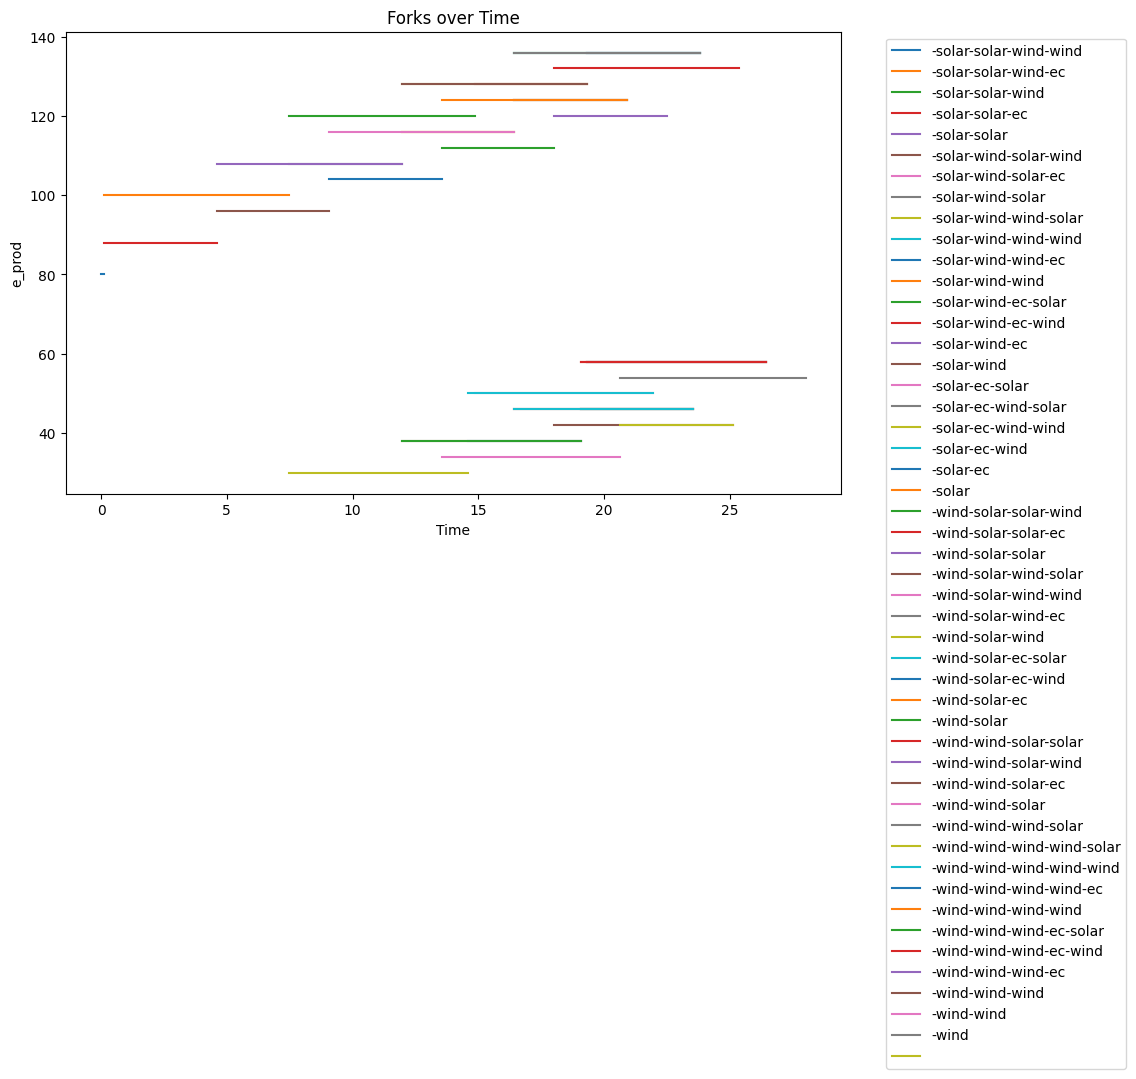

In [16]:
import matplotlib.pyplot as plt

def plot_forks(fork, ax, x_start, legend_labels):
    x_end = x_start + fork.bt
    e_prod = (fork.df.e_prod * fork.df['cnt']).sum()
    ax.plot([x_start, x_end], [e_prod, e_prod], label=fork.name)
    
    for branch in fork.branches:
        plot_forks(branch, ax, x_end, legend_labels)
    
    legend_labels.append(fork.name)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the forks recursively
legend_labels = []
plot_forks(branch, ax, 0, legend_labels)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('e_prod')
ax.set_title('Forks over Time')

# Show the legend
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()